<a href="https://colab.research.google.com/github/jyoti-sn/Elections/blob/main/Electoral_bond_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install tabula-py
!pip install tabula-py[jpype]
!pip install datasets
import tabula
import pandas as pd
import numpy as np
import re

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.0/12.0 MB 39.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 488.6/488.6 kB 5.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 510.5/510.5 kB 5.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 10.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 8.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 12.5 MB/s eta 0:00:00


## Data loading

---



In [5]:
# convert PDF into CSV file
tabula.convert_into("/content/Purchaser.pdf", "bond_data_purchase.csv", output_format="csv", pages='all')
tabula.convert_into("/content/parties.pdf", "bond_data_parties.csv", output_format="csv", pages='all')

df_c = pd.read_csv('bond_data_purchase.csv')
df_p = pd.read_csv('bond_data_parties.csv')

print ('Purchasers dataset shape is ' + str(df_c.shape)) #20422
print ('Parties dataset shape is ' + str(df_p.shape)) #18872

Purchasers dataset shape is (19256, 12)
Parties dataset shape is (20972, 9)


## Data cleaning

---



In [8]:
def clean_dataframe(df):
    df = df.loc[~df.duplicated()]
    return df

In [9]:
df_c = clean_dataframe(df_c)
df_p = clean_dataframe(df_p)

print('purchaser file shape is ', df_c.shape) #18872
print('parties file shape is ', df_p.shape) #20422

purchaser file shape is  (18872, 12)
parties file shape is  (20422, 9)


In [12]:
# Function to clean column names
def clean_column_names(columns):
    # Remove any whitespace, parentheses, and newline characters; convert to lowercase
    cleaned_columns = [re.sub(r'[\(\)\.\r\n]', '', col).lower().replace(' ', '_') for col in columns]
    return cleaned_columns

# Clean the column names
df_c.columns = clean_column_names(df_c.columns)
df_p.columns = clean_column_names(df_p.columns)

In [14]:
df_c.columns

Index(['sr_no', 'reference_no__urn', 'journal_date', 'date_ofpurchase',
       'date_of_expiry', 'name_of_the_purchaser', 'prefix', 'bondnumber',
       'denominations', 'issue_branch_code', 'issue_teller', 'status'],
      dtype='object')

In [15]:
df_p.columns

Index(['sr_no', 'date_ofencashment', 'name_of_the_political_party',
       'account_no_ofpolitical_party', 'prefix', 'bondnumber', 'denominations',
       'pay_branchcode', 'pay_teller'],
      dtype='object')

In [24]:
# Rename columns
df_c = df_c.rename(columns={
    'date_ofpurchase': 'date_of_purchase',
})

df_p = df_p.rename(columns={
    'date_ofencashment': 'date_of_encashment',
    'account_no_ofpolitical_party': 'account_no_of_political_party'
})

print(df_c.columns)
print(df_p.columns)

Index(['sr_no', 'reference_no__urn', 'date_of_purchase', 'date_of_expiry',
       'name_of_the_purchaser', 'prefix', 'bondnumber', 'denominations',
       'issue_branch_code', 'issue_teller', 'status'],
      dtype='object')
Index(['sr_no', 'date_of_encashment', 'name_of_the_political_party',
       'account_no_of_political_party', 'prefix', 'bondnumber',
       'denominations', 'pay_branchcode', 'pay_teller'],
      dtype='object')


In [18]:
# Drop the 'journal_date' column if it exists
if 'journal_date' in df_c.columns:
    df_c = df_c.drop(columns=['journal_date'])

# Convert datetime columns to datetime format
# Assuming the names of all columns that contain datetime information are known and listed in datetime_columns
datetime_columns_c = ['date_of_purchase', 'date_of_expiry']

# Iterate over the list of datetime columns and convert them using pd.to_datetime
for col in datetime_columns_c:
    if col in df_c.columns:
        df_c[col] = pd.to_datetime(df_c[col], errors='coerce')

# For the parties file DataFrame 'cleaned_df_p', assuming it has similar datetime columns that need conversion
if 'date_of_encashment' in df_p.columns:
    df_p['date_of_encashment'] = pd.to_datetime(df_p['date_of_encashment'], errors='coerce')

## Dataframe merge

---



In [75]:
# This time, we ensure all rows from df_p are preserved using a right join
merged_df = pd.merge(df_c, df_p, on=['bondnumber', 'prefix'], how='outer', suffixes=('_c', '_p'))

print ('merged_df shape before dropping the duplicates is ' + str(merged_df.shape))

merged_df shape before dropping the duplicates is (20552, 18)


In [76]:
# Replace commas with empty strings and convert the column to numeric, handling errors by coercing to NaN
merged_df['denominations_p'] = pd.to_numeric(merged_df['denominations_p'].str.replace(',', ''), errors='coerce')

# encashed_donations_crores
merged_df['encashed_donations_crores'] = merged_df['denominations_p'] / 10000000

merged_df.groupby(by='name_of_the_political_party')['encashed_donations_crores'].sum()

name_of_the_political_party
AAM AADMI PARTY                                                   65.4500
ADYAKSHA SAMAJVADI PARTY                                          14.0500
ALL INDIA ANNA DRAVIDA MUNNETRA KAZHAGAM                           6.0500
ALL INDIA TRINAMOOL CONGRESS                                    1609.5314
BHARAT RASHTRA SAMITHI                                          1214.7099
BHARATIYA JANATA PARTY                                          6060.5111
BIHAR PRADESH JANTA DAL(UNITED)                                   14.0000
BIJU JANATA DAL                                                  775.5000
DRAVIDA MUNNETRA KAZHAGAM (DMK)                                  639.0000
GOA FORWARD PARTY                                                  0.3500
JAMMU AND KASHMIR NATIONAL CONFERENCE                              0.5000
JANASENA PARTY                                                    21.0000
JANATA DAL ( SECULAR )                                            43.5000
JHARKHAND 

In [91]:
df = merged_df[['date_of_purchase', 'date_of_expiry',
       'name_of_the_purchaser','bondnumber', 'date_of_encashment', 'name_of_the_political_party', 'encashed_donations_crores']]

In [92]:
df.head()

,date_of_purchase,date_of_expiry,name_of_the_purchaser,bondnumber,date_of_encashment,name_of_the_political_party,encashed_donations_crores
0,2019-04-12,2019-04-26,A B C INDIA LIMITED,11448,2019-04-25,BHARATIYA JANATA PARTY,0.10
1,2019-04-12,2019-04-26,A B C INDIA LIMITED,11447,2019-04-25,BHARATIYA JANATA PARTY,0.10
2,2019-04-12,2019-04-26,A B C INDIA LIMITED,11441,2019-04-25,BHARATIYA JANATA PARTY,0.10
3,2019-04-12,2019-04-26,A B C INDIA LIMITED,1113,2019-04-25,BHARATIYA JANATA PARTY,0.01
4,2019-04-12,2019-04-26,A B C INDIA LIMITED,1118,2019-04-25,BHARATIYA JANATA PARTY,0.01


In [93]:
df['encashed_donations_crores'].sum()

12769.0893

In [94]:
df.dtypes

date_of_purchase               datetime64[ns]
date_of_expiry                 datetime64[ns]
name_of_the_purchaser                  object
bondnumber                             object
date_of_encashment             datetime64[ns]
name_of_the_political_party            object
encashed_donations_crores             float64
dtype: object

In [95]:
df = df.copy()
df['days_to_encash'] = (df['date_of_encashment'] - df['date_of_purchase']).dt.days

In [96]:
df.head(n=20)

,date_of_purchase,date_of_expiry,name_of_the_purchaser,bondnumber,date_of_encashment,name_of_the_political_party,encashed_donations_crores,days_to_encash
0,2019-04-12,2019-04-26,A B C INDIA LIMITED,11448,2019-04-25,BHARATIYA JANATA PARTY,0.10,13.0
1,2019-04-12,2019-04-26,A B C INDIA LIMITED,11447,2019-04-25,BHARATIYA JANATA PARTY,0.10,13.0
2,2019-04-12,2019-04-26,A B C INDIA LIMITED,11441,2019-04-25,BHARATIYA JANATA PARTY,0.10,13.0
3,2019-04-12,2019-04-26,A B C INDIA LIMITED,1113,2019-04-25,BHARATIYA JANATA PARTY,0.01,13.0
4,2019-04-12,2019-04-26,A B C INDIA LIMITED,1118,2019-04-25,BHARATIYA JANATA PARTY,0.01,13.0
5,2019-04-12,2019-04-26,A B C INDIA LIMITED,1112,2019-04-25,BHARATIYA JANATA PARTY,0.01,13.0
6,2019-04-12,2019-04-26,A B C INDIA LIMITED,1115,2019-04-25,BHARATIYA JANATA PARTY,0.01,13.0
7,2019-04-12,2019-04-26,A B C INDIA LIMITED,1119,2019-04-25,BHARATIYA JANATA PARTY,0.01,13.0
8,2019-04-12,2019-04-26,A B C INDIA LIMITED,1110,2019-04-25,BHARATIYA JANATA PARTY,0.01,13.0
9,2019-04-12,2019-04-26,A B C INDIA LIMITED,1111,2019-04-25,BHARATIYA JANATA PARTY,0.01,13.0


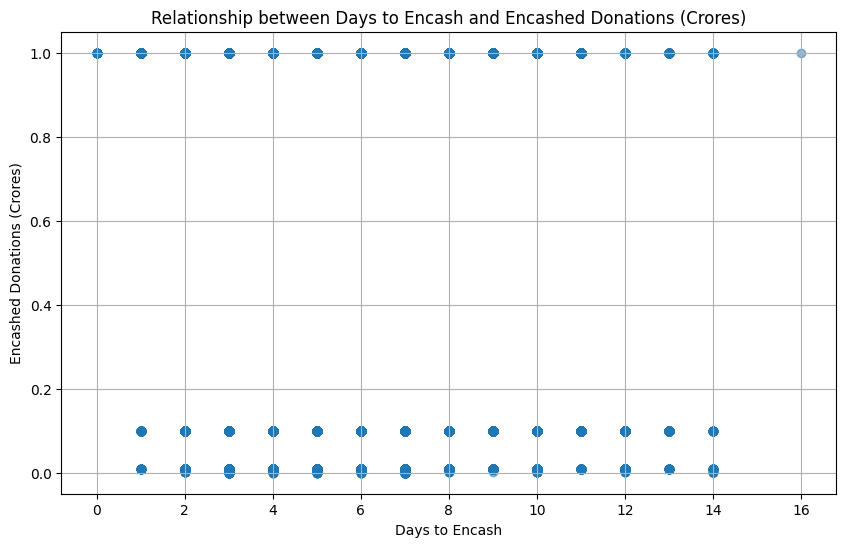

In [100]:
import matplotlib.pyplot as plt

# Assuming 'merged_df' is your DataFrame and it contains 'days_to_encash' and 'encashed_donations_crores'
plt.figure(figsize=(10, 6))  # Set the figure size for better readability

# Create a scatter plot
plt.scatter(df['days_to_encash'], df['encashed_donations_crores'], alpha=0.5)

# Adding title and labels
plt.title('Relationship between Days to Encash and Encashed Donations (Crores)')
plt.xlabel('Days to Encash')
plt.ylabel('Encashed Donations (Crores)')

# Show plot
plt.grid(True)  # Add grid for better readability
plt.show()

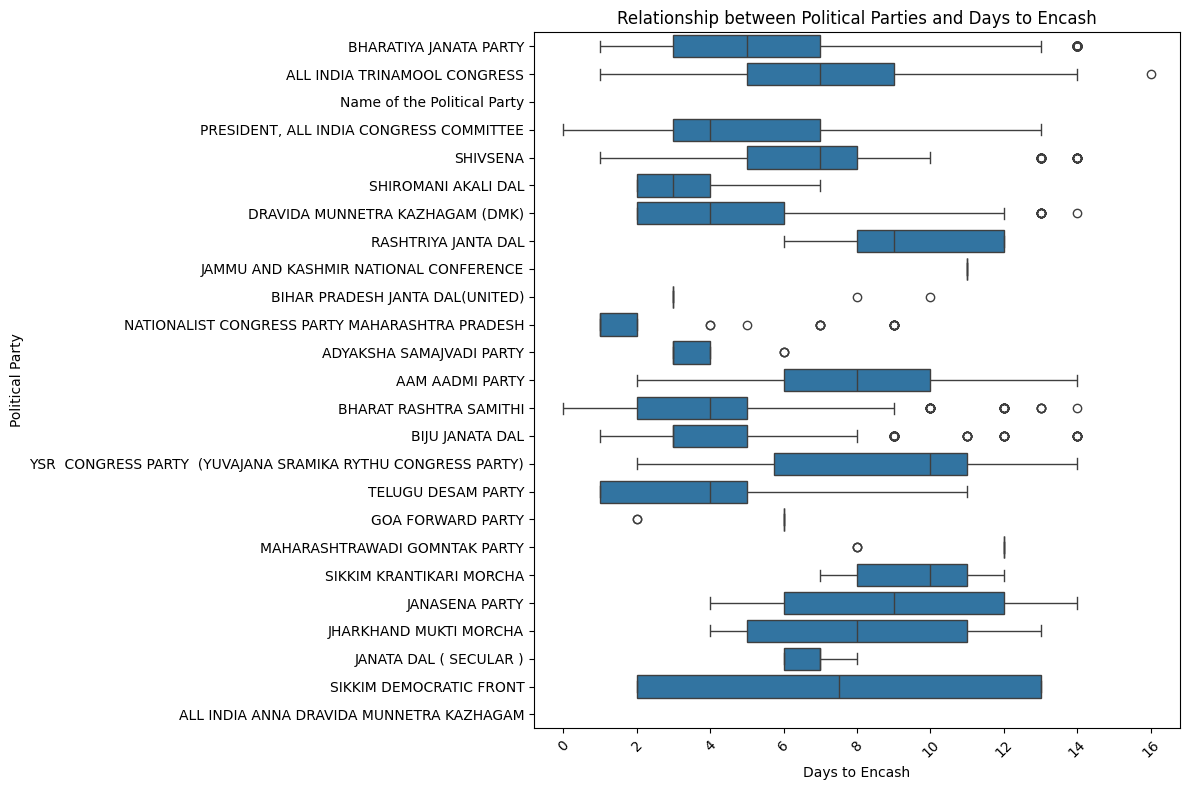

In [101]:
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming 'merged_df' is your DataFrame
plt.figure(figsize=(12, 8))  # Set the figure size for better readability

# Create a box plot
sns.boxplot(x='days_to_encash', y='name_of_the_political_party', data=df)

# Adding title and labels
plt.title('Relationship between Political Parties and Days to Encash')
plt.xlabel('Days to Encash')
plt.ylabel('Political Party')

# Improve layout for better readability of party names
plt.xticks(rotation=45)  # Rotate x-axis labels to prevent overlap
plt.tight_layout()  # Adjust layout to make room for the rotated x-axis labels

# Show plot
plt.show()


In [105]:
from datasets import Dataset
dataset = Dataset.from_pandas(df)

In [106]:
!huggingface-cli login


    _|    _|  _|    _|    _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|_|_|_|    _|_|      _|_|_|  _|_|_|_|
    _|    _|  _|    _|  _|        _|          _|    _|_|    _|  _|            _|        _|    _|  _|        _|
    _|_|_|_|  _|    _|  _|  _|_|  _|  _|_|    _|    _|  _|  _|  _|  _|_|      _|_|_|    _|_|_|_|  _|        _|_|_|
    _|    _|  _|    _|  _|    _|  _|    _|    _|    _|    _|_|  _|    _|      _|        _|    _|  _|        _|
    _|    _|    _|_|      _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|        _|    _|    _|_|_|  _|_|_|_|

    To login, `huggingface_hub` requires a token generated from https://huggingface.co/settings/tokens .
Token: 
Add token as git credential? (Y/n) Y
Token is valid (permission: write).
Cannot authenticate through git-credential as no helper is defined on your machine.
You might have to re-authenticate when pushing to the Hugging Face Hub.
Run the following command in your terminal in case you want to set the 'store' creden

In [107]:
dataset.push_to_hub("JyotiNayak/Indian_electoral_bond_dataset")

Uploading the dataset shards:   0%|          | 0/1 [00:00<?, ?it/s]

Creating parquet from Arrow format:   0%|          | 0/21 [00:00<?, ?ba/s]

CommitInfo(commit_url='https://huggingface.co/datasets/JyotiNayak/Indian_electoral_bond_dataset/commit/2909ac2cec824ffe42bae3349bf95781428c4ecc', commit_message='Upload dataset', commit_description='', oid='2909ac2cec824ffe42bae3349bf95781428c4ecc', pr_url=None, pr_revision=None, pr_num=None)